In [1]:
# Importing necessary libraries for data cleaning and exploration

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

from Utils.preprocessing import *
from Utils.customPipelines import *

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE=632

# Load and Clean df
- Check row types are consistent (all float64)
- Check for duplicates
- Check for NaN values
- Check date format and sequence is correct
- Check for negative values in signal & ETF prices

In [2]:
# Load the dataset
df = pd.read_csv('data\\QF632_Project_1.csv')

# Change date format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

columns_to_check = ['Signal', 'Open', 'High', 'Low', 'Close', 'Adj Close']
# Correcting negative/zero historical prices and signal values using forward fill
for col in columns_to_check:
    # Replace zero and negative values with NaN
    df[col] = df[col].mask(df[col] <= 0)
    
    # Forward fill NaN values
    df[col].fillna(method='ffill', inplace=True)

In [3]:
# Examine the structure and summary
print(df.info())
print(df.describe())
print()

# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)
print()

# Check for duplicates
duplicates = df.duplicated().sum()
print("Number of duplicate rows:", duplicates)
print()

# Ensure dates are in the right format and sequence
date_check = df['Date'].apply(pd.to_datetime, errors='coerce').isnull().sum()
print(f"Invalid dates: {date_check}")

# Check for date sequence issues
date_order_issues = (df['Date'] != df['Date'].sort_values()).any()
if date_order_issues:
    print("Dates are out of order")
else:
    print("Dates are in correct order")
print()

# Ensure prices and signals are non-zero and positive
columns_to_check = ['Signal', 'Open', 'High', 'Low', 'Close', 'Adj Close']
value_check = {col: (df[col] < 0).sum() for col in columns_to_check}

print(f"Negative/zero values: {value_check}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1038 non-null   datetime64[ns]
 1   Signal     1038 non-null   float64       
 2   Open       1038 non-null   float64       
 3   High       1038 non-null   float64       
 4   Low        1038 non-null   float64       
 5   Close      1038 non-null   float64       
 6   Adj Close  1038 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 56.9 KB
None
            Signal         Open         High          Low        Close  \
count  1038.000000  1038.000000  1038.000000  1038.000000  1038.000000   
mean     16.881893   141.847360   142.691801   140.907746   141.840973   
std       2.829337    18.475574    18.470255    18.404504    18.497010   
min      10.582996    94.080002    95.400002    93.639999    94.790001   
25%      14.842406   132.132496   13

# Analyse the data

In [4]:
# We want to difference the data to find the n-day returns
def get_differenced_data(df_temp, p):
    df_diff = df_temp[[col for col in df.columns if col != 'Date']].diff(periods=p)
    df_diff["Date"] = df_temp["Date"]
    return df_diff

df_differenced = get_differenced_data(df.copy(), 1)

## Boxplots

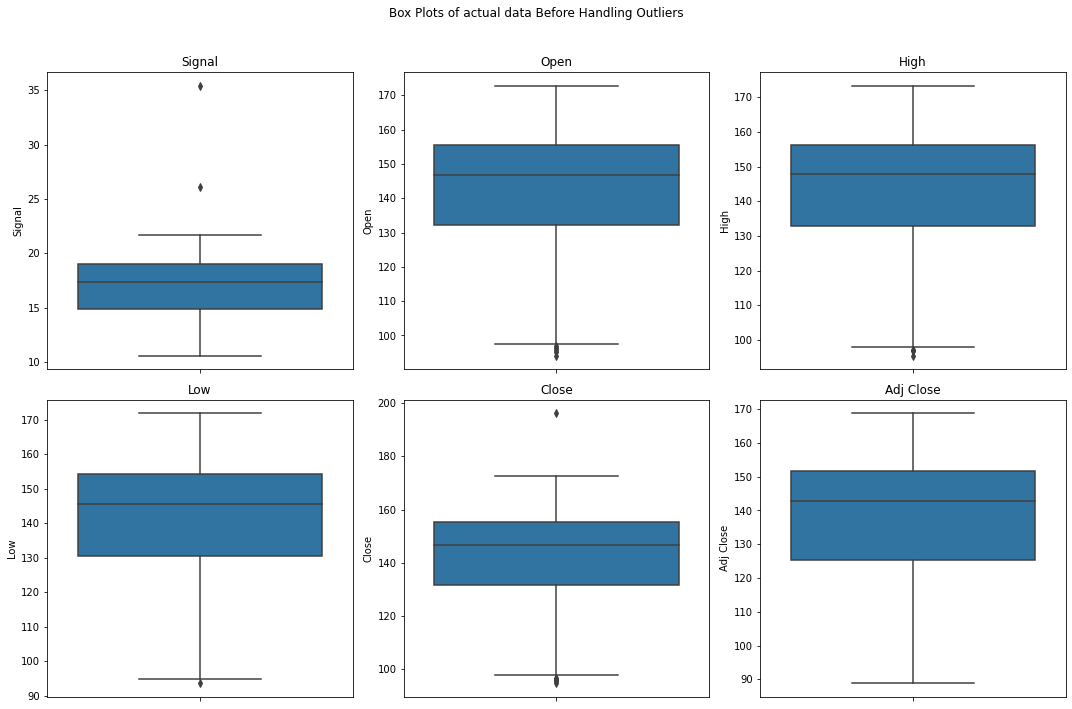

In [5]:
# Plot box plots before handling outliers
plt.figure(figsize=(15, 10))
plt.suptitle('Box Plots of actual data Before Handling Outliers')

for i, col in enumerate(columns_to_check, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col])
    plt.title(col)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Extreme high outliers:
- Signal has 2 points 
- Close has 1 oint

Extreme low points:
- All columns except Adj Close

This is interesting as this means that after removing all volatility from day to day trades as well as taking into account corporate actions such as stock splits, dividends, and mergers, the actual returns of ETF does not have any outliers.

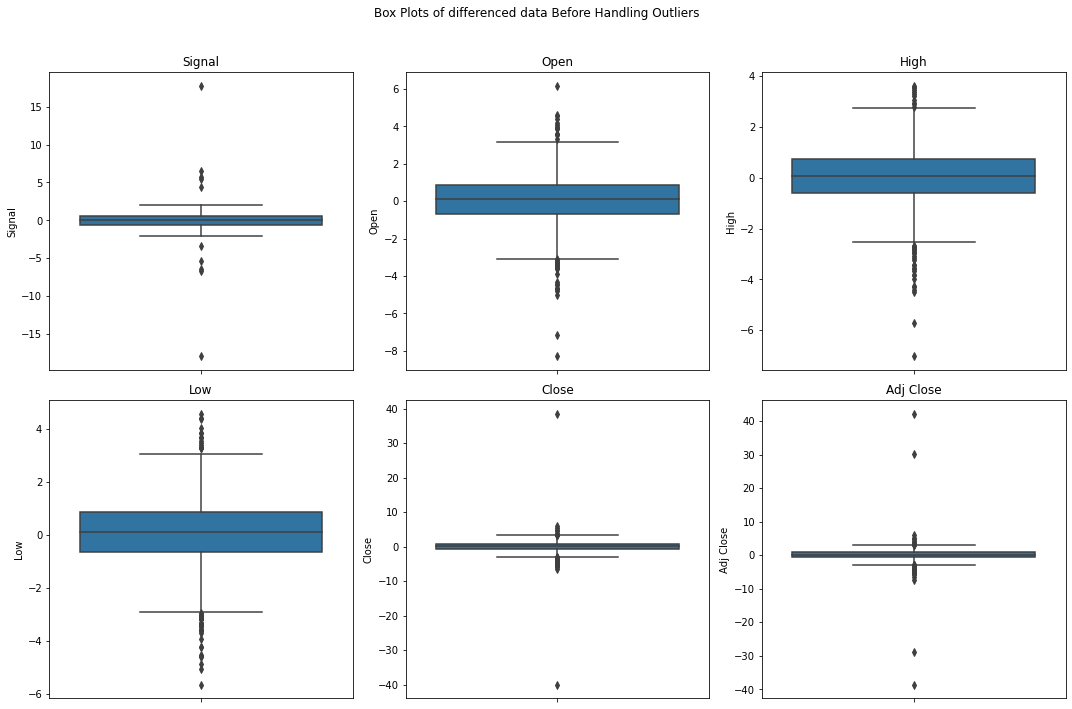

In [6]:
# Plot box plots before handling outliers
plt.figure(figsize=(15, 10))
plt.suptitle('Box Plots of differenced data Before Handling Outliers')

for i, col in enumerate(columns_to_check, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df_differenced[col])
    plt.title(col)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Visualising the data

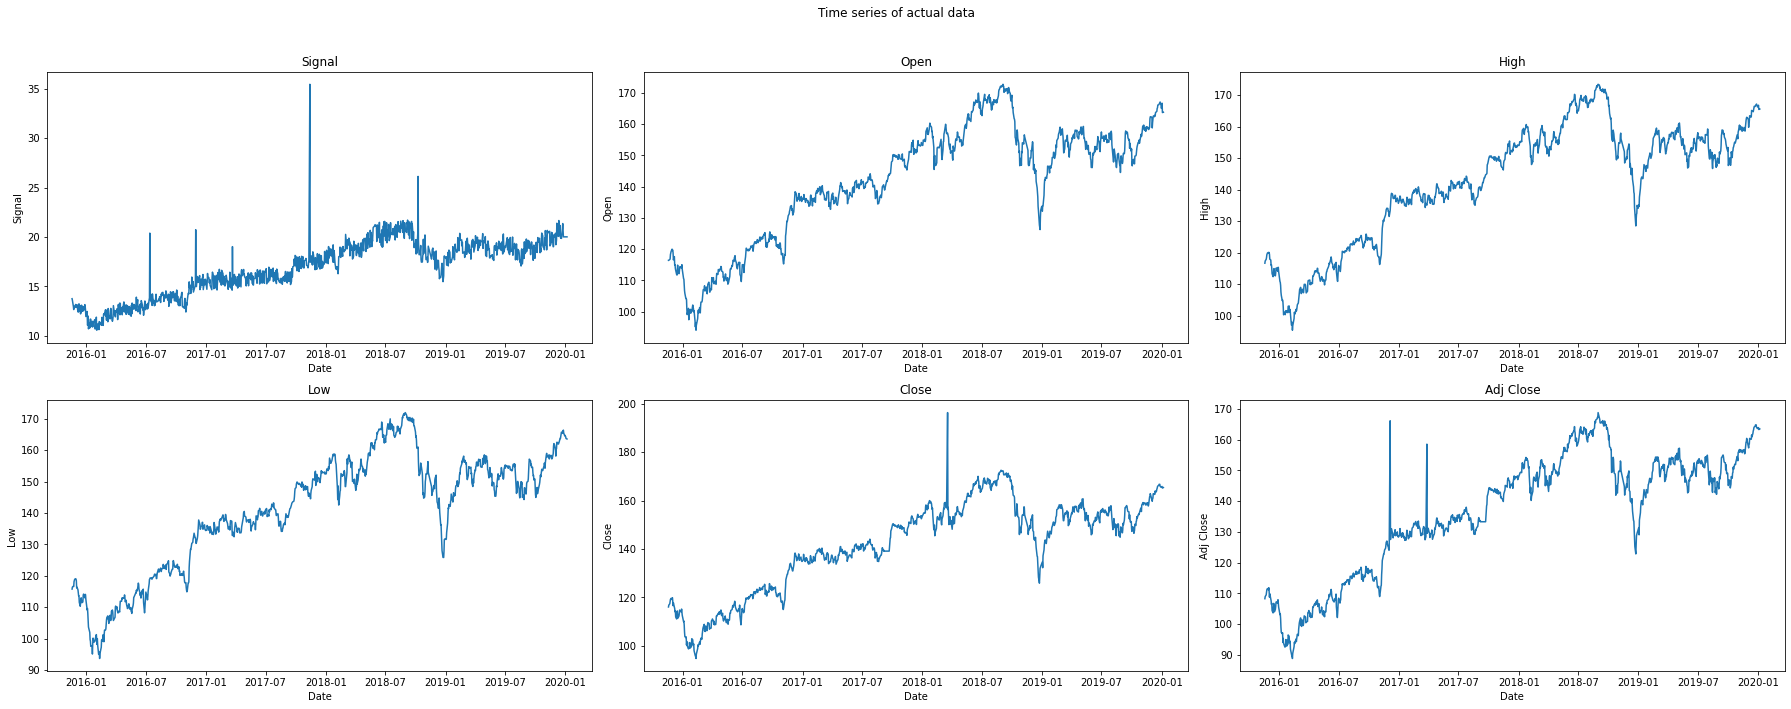

In [7]:
# Plot time series
plt.figure(figsize=(25, 10))
plt.suptitle('Time series of actual data')

for i, col in enumerate(columns_to_check, 1):
    plt.subplot(2, 3, i)
    sns.lineplot(x=df.Date, y=df[col])
    plt.title(col)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

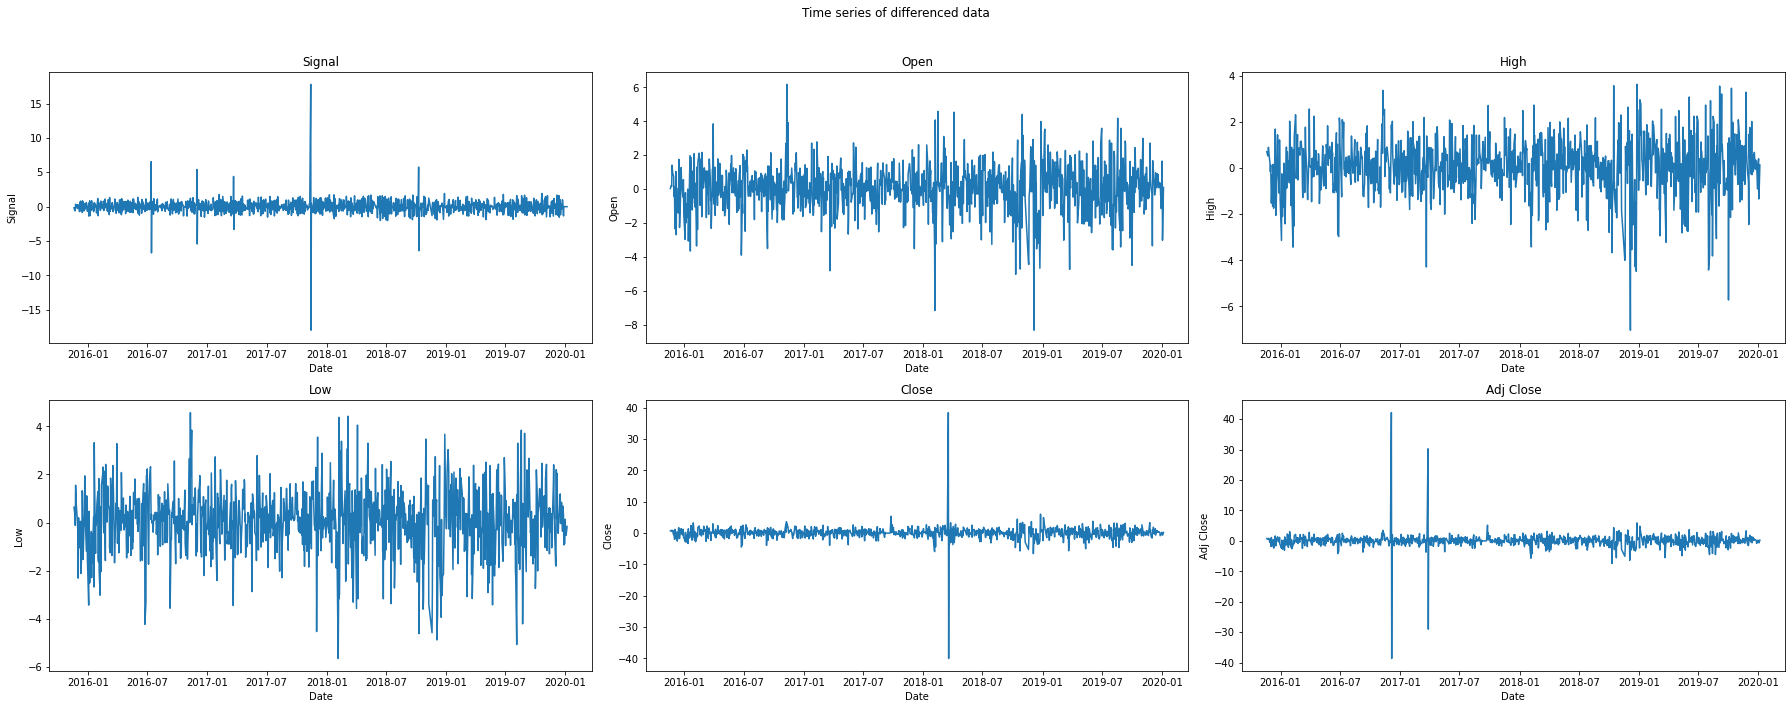

In [8]:
# Plot time series
plt.figure(figsize=(25, 10))
plt.suptitle('Time series of differenced data')

for i, col in enumerate(columns_to_check, 1):
    plt.subplot(2, 3, i)
    sns.lineplot(x=df_differenced.Date, y=df_differenced[col])
    plt.title(col)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Time series decomposition

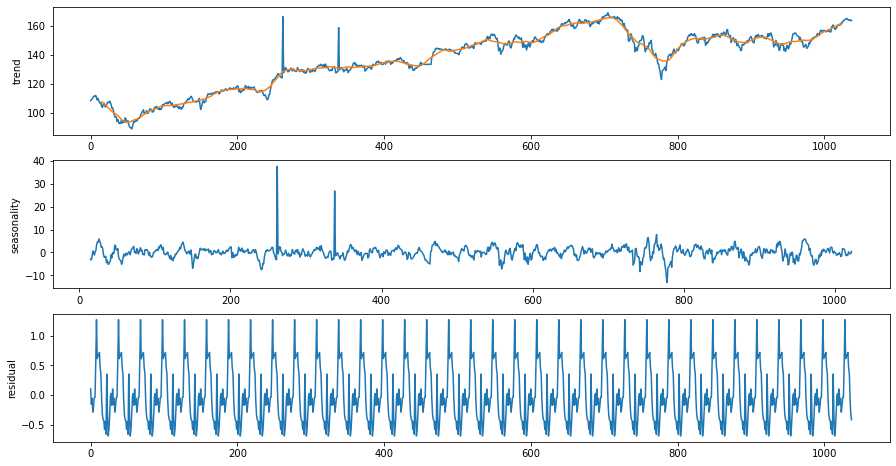

In [9]:
res = seasonal_decompose(df["Adj Close"], model = "additive",period = 30)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
res.observed.plot(ax=ax1,ylabel = "trend")
res.trend.plot(ax=ax1,ylabel = "trend")
res.resid.plot(ax=ax2,ylabel = "seasonality")
res.seasonal.plot(ax=ax3,ylabel = "residual")
plt.show()

## ACF/PACF

Autocorrelation represents the degree of similarity between a given time series and a lagged version of itself over successive time intervals. In other words, it measures the relationship between a variable’s current value and its past values.

PACF measures the relationship between a variable’s current value and its past values unconditional to the preceeding lags.


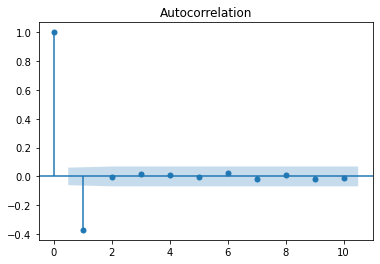

In [10]:
sm.graphics.tsa.plot_acf(df_differenced["Adj Close"].dropna(), lags=10)
plt.show()

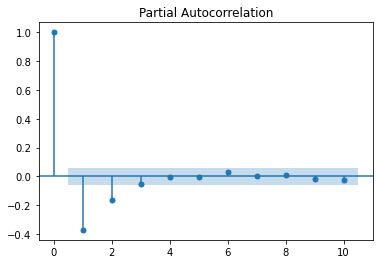

In [11]:
sm.graphics.tsa.plot_pacf(df_differenced["Adj Close"].dropna(), lags=10)
plt.show()

ACF is significant at lag 1, whereas PACF is shows a geometric decay at each m lag. This can signify a moving average (MA) component in an ARIMA model is used.  

# Other interesting exploratory data analysis
Moving average volatility 20 day window

In [12]:
# Calculate daily returns for given column
def calculate_daily_returns(df_temp, column, p = 1):
    df_temp[f'{column} Daily Return'] = df_temp[column].pct_change(periods = p)
    return df_temp.dropna()

# Calculate rolling volatility for given column
def calculate_rolling_volatility(df_temp, column, window=20):
    df_temp[f'{column} Rolling Volatility'] = df_temp[f'{column} Daily Return'].rolling(window=window).std() * np.sqrt(window)
    return df_temp.dropna()

# Main function
def analyze_volatility(df_temp):
    df_temp['Date'] = pd.to_datetime(df_temp['Date'])
    
    # Calculate daily returns and rolling volatility for Adj Close
    df_temp = calculate_daily_returns(df_temp, 'Adj Close')
    df_temp = calculate_rolling_volatility(df_temp, 'Adj Close')
    
    # Calculate daily returns and rolling volatility for Signal
    df_temp = calculate_daily_returns(df_temp, 'Signal')
    df_temp = calculate_rolling_volatility(df_temp, 'Signal')
    
    return df_temp

# Load and analyze data
df_volatility = analyze_volatility(df.copy())

# Output the results
print("Data with Daily Returns and Rolling Volatility:")
df_volatility

Data with Daily Returns and Rolling Volatility:


,Date,Signal,Open,High,Low,Close,Adj Close,Adj Close Daily Return,Adj Close Rolling Volatility,Signal Daily Return,Signal Rolling Volatility
40,2016-01-20,11.479756,97.430000,100.330002,95.059998,99.180000,92.934502,0.004151,0.061426,0.049102,0.250234
41,2016-01-21,10.913312,99.330002,100.910004,98.379997,98.949997,92.718971,-0.002319,0.059995,-0.049343,0.250618
42,2016-01-22,11.435968,100.650002,101.610001,100.129997,101.370003,94.986595,0.024457,0.065740,0.047892,0.252877
43,2016-01-25,11.433675,100.739998,101.080002,98.849998,99.120003,92.878281,-0.022196,0.064994,-0.000201,0.252856
44,2016-01-26,11.577177,99.519997,101.400002,99.180000,101.099998,94.733612,0.019976,0.069925,0.012551,0.251964
...,...,...,...,...,...,...,...,...,...,...,...
1033,2019-12-30,20.016643,165.979996,166.210007,164.570007,165.440002,163.623688,-0.002532,0.022656,0.000000,0.207244
1034,2019-12-31,20.016643,165.080002,166.350006,164.710007,165.669998,163.851135,0.001390,0.019427,0.000000,0.206301
1035,2020-01-02,20.016643,166.740005,166.750000,164.229996,165.779999,163.959946,0.000664,0.018741,0.000000,0.197408
1036,2020-01-03,20.016643,163.740005,165.410004,163.699997,165.130005,163.317093,-0.003921,0.018930,0.000000,0.197336


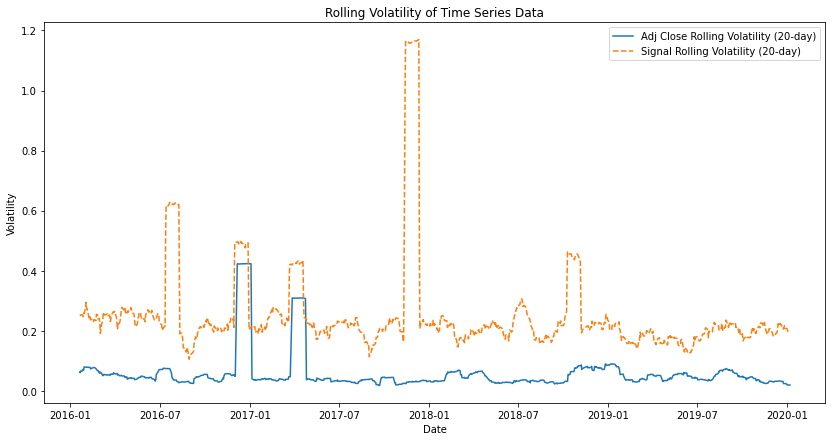

In [13]:
# Plotting the combined rolling volatility
plt.figure(figsize=(14, 7))
plt.plot(df_volatility['Date'], df_volatility['Adj Close Rolling Volatility'], label='Adj Close Rolling Volatility (20-day)')
plt.plot(df_volatility['Date'], df_volatility['Signal Rolling Volatility'], label='Signal Rolling Volatility (20-day)', linestyle='--')
plt.title('Rolling Volatility of Time Series Data')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

In [14]:
# Descriptive statistics
print("\nDescriptive Statistics for Adj Close Rolling Volatility:")
print(df_volatility['Adj Close Rolling Volatility'].describe())
print("\nDescriptive Statistics for Signal Rolling Volatility:")
print(df_volatility['Signal Rolling Volatility'].describe())


Descriptive Statistics for Adj Close Rolling Volatility:
count    998.000000
mean       0.056723
std        0.065785
min        0.017176
25%        0.031884
50%        0.039713
75%        0.055303
max        0.423132
Name: Adj Close Rolling Volatility, dtype: float64

Descriptive Statistics for Signal Rolling Volatility:
count    998.000000
mean       0.250588
std        0.156158
min        0.104887
25%        0.190473
50%        0.214505
75%        0.239967
max        1.169732
Name: Signal Rolling Volatility, dtype: float64


# Preprocessing

## Outlier Handling
Replacing data points with last observed if change is more than 10 times the average move.
- Start from 1/3 of the data, if any point has a change > 10 * the average before itself, replaced with previous point

In [15]:
# Function to handle large increases by forward filling
def handle_large_increases_ffill(df_temp, columns, multiplier):
    # Calculate the differences between consecutive data points
    differences = df_temp[columns].diff()
    
    # Identify data points with increases more than 10 times the average move
    for col in columns:
        large_increases = []
        col_diff = differences[col]
        for i in range(len(differences)//5, len(differences)):
            threshold = col_diff[:i-1].abs().mean() * multiplier
            if col_diff[i] > threshold:
                large_increases.append(i)
    
        # Replace data points with large increases with NaN
        # return df_temp.iloc[large_increases, :][col]
        df_temp.at[large_increases, col] = float('nan')
        # Forward fill NaN values
        df_temp[col].fillna(method='ffill', inplace=True)
    
        print(f"Number of data points with increases more than {multiplier} times the average move in {col}: {len(large_increases)}")
    return df_temp

Number of data points with increases more than 10 times the average move in Signal: 1


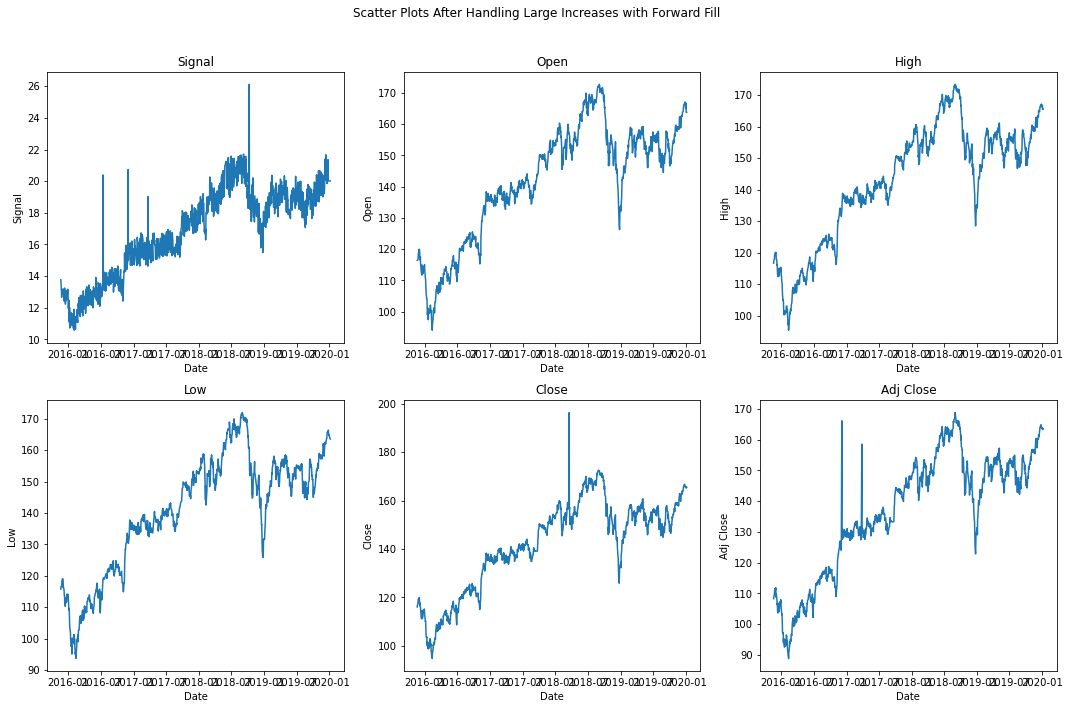

In [16]:
multiplier = 10
columns = ["Signal"]
df_outlier_imputed = handle_large_increases_ffill(df.copy(), columns, multiplier)

# Plot scatter plots after handling large increases
plt.figure(figsize=(15, 10))
plt.suptitle('Scatter Plots After Handling Large Increases with Forward Fill')

for i, col in enumerate(columns_to_check, 1):
    plt.subplot(2, 3, i)
    sns.lineplot(x=df_outlier_imputed.Date, y=df_outlier_imputed[col])
    plt.title(col)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Analyzing the signal’s effectiveness

## Cross correlation

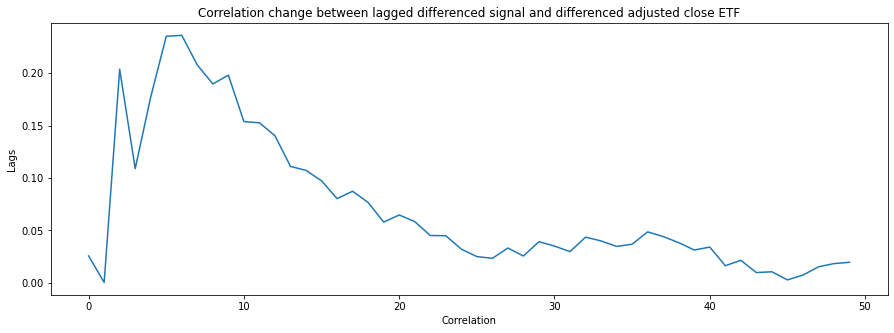

In [17]:
horizon = 50
lags = []
collated_corr = []
for h in range(1, horizon+1):
    df_diff_temp = get_differenced_data(df.copy(), h)
    df_diff_lagged = df_diff_temp.copy()
    df_diff_lagged["Signal"] = df_diff_temp["Signal"].shift(h)
    df_diff_lagged = df_diff_lagged.dropna()
    collated_corr.append(abs(np.corrcoef(df_diff_lagged["Signal"], df_diff_lagged["Adj Close"])[0][1]))
    lags.append("Lag" + str(h))

df_cross_corr = pd.DataFrame()
df_cross_corr["Lag_no"] = lags
df_cross_corr["Corr"] = collated_corr

plt.figure(figsize=(15,5))
plt.title("Correlation change between lagged differenced signal and differenced adjusted close ETF")
plt.xlabel("Correlation")
plt.ylabel("Lags")
plt.plot(df_cross_corr["Corr"])
plt.show()

From the above graph, we can see that the rate of change of signal has the highest correlation with adjusted close ETF returns at lag 6. This can mean that the signal from 6 time lags ago is the best at predicting today's adjusted close ETF. However even so, the maximum correlation between the signal and the adjusted close ETF returns is at 0.3, which is low. Hence, it can be inferred here that signal may not be a good predictor of adjusted close ETF returns.

# Feature selection with regularized regressions

In [18]:
def setup_data_for_modelling(df_temp, forecast_horizon):
    df_for_regression = get_differenced_data(df_temp.copy(), forecast_horizon)
    df_for_regression = df_for_regression.rename(columns={"Adj Close": "y"})
    df_for_regression = df_for_regression.drop(columns = ["Open", "High", "Low", "Close"])

    # We need to shift the features to ensure fair forecasting
    df_for_regression["Signal"] = df_for_regression["Signal"].shift(forecast_horizon)

    # Create lags for linear regression
    lags_required = 1
    for l in range(forecast_horizon, lags_required+1):
        df_for_regression["lag"+str(l)] = df_for_regression["y"].shift(l)

    return df_for_regression.dropna()

In [19]:
h = 1
df_for_regression = setup_data_for_modelling(df_outlier_imputed.copy(), h)
X, y, X_train, X_test, y_train, y_test = get_standard_train_test_split(df_for_regression, test_ratio=0.2, is_not_time_series = False)

## Baseline: Naive

Actual Adj Close Price vs Predicted Adj Close Price
Root Mean Squared Error: 2.20
Mean Absolute Error: 1.72
Std: 1.50


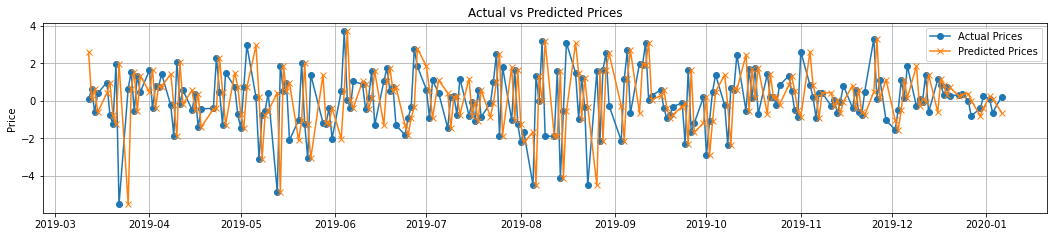

In [20]:
models_performance = {}

pred = df_for_regression["y"].shift(h).tolist()[-len(X_test):]
mae = mean_absolute_error(pred, y_test)
rmse = mean_squared_error(pred, y_test) ** 0.5

models_performance["Naive"] = [mae, rmse, np.std(pred)]

print(f'\033[1mActual Adj Close Price vs Predicted Adj Close Price\033[0m')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Std: {np.std(pred):.2f}')

# To visualise the performance of the model
plt.figure(figsize = (18, 3.5))
plt.plot(X_test.Date, y_test.values, label = 'Actual Prices', marker = 'o')
plt.plot(X_test.Date, pred, label = 'Predicted Prices', marker = 'x')
plt.title('Actual vs Predicted Prices')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## Lasso Feature Selector

Actual Adj Close Price vs Predicted Adj Close Price
Root Mean Squared Error: 1.51
Mean Absolute Error: 1.13
Std: 0.40


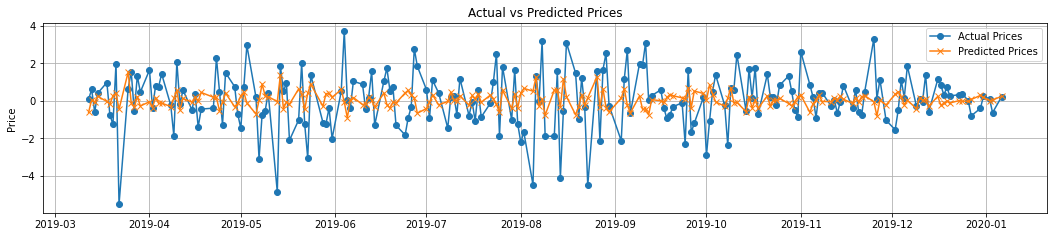

In [21]:
features = [i for i in X_train.columns if i not in ["y", "Date"]]

preprocess_lr = Pipeline([
  ('feature_selector', FeatureSelector(features)),
  ('numerical_imputer', CustomImputer(impute_type='numerical')),
  ('lasso_regressor', Lasso(random_state=RANDOM_STATE))
])

preprocess_lr.fit(X_train, y_train)
pred = preprocess_lr.predict(X_test)

mae = mean_absolute_error(pred, y_test)
rmse = mean_squared_error(pred, y_test) ** 0.5

models_performance["Lasso"] = [mae, rmse, np.std(pred)]

# models_performance["Lasso"] = [mae, r2, np.std(pred)]

print(f'\033[1mActual Adj Close Price vs Predicted Adj Close Price\033[0m')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Std: {np.std(pred):.2f}')

# To visualise the performance of the model
plt.figure(figsize = (18, 3.5))
plt.plot(X_test.Date, y_test.values, label = 'Actual Prices', marker = 'o')
plt.plot(X_test.Date, pred, label = 'Predicted Prices', marker = 'x')
plt.title('Actual vs Predicted Prices')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

['Signal', 'lag1']


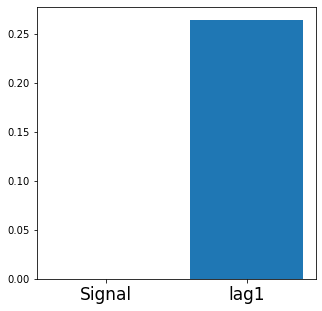

In [22]:
preprocess_lr.fit(X_train, y_train)

# get importance
importance = np.abs(preprocess_lr['lasso_regressor'].coef_)

# get index of top N important values
n = 10
indexes = sorted(range(len(importance)), key=lambda i: importance[i])[-n:]
impt_features = []
impt_features_score = []
# summarize feature importance
for i in indexes:
 impt_features.append(features[i])
 impt_features_score.append(importance[i])
# plot feature importance
plt.figure(figsize=(5, 5))
plt.xticks(fontsize=17)

print(impt_features)
plt.bar(impt_features, impt_features_score)
plt.show()


# Feature Importance

## Random Forest

Actual Adj Close Price vs Predicted Adj Close Price
Root Mean Squared Error: 1.75
Mean Absolute Error: 1.27
Std: 1.01


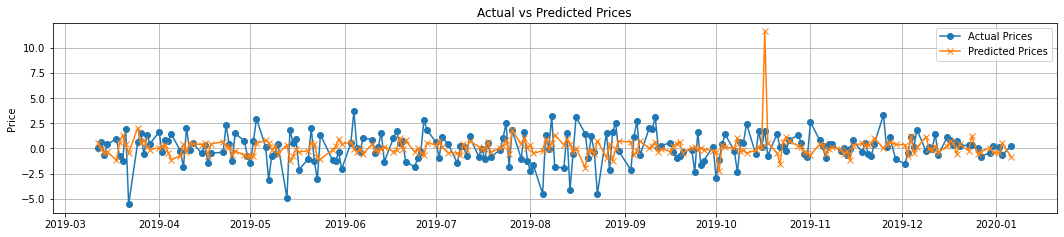

In [23]:
features = [i for i in X_train.columns if i not in ["y", "Date"]]

rf_lr = Pipeline([
  ('feature_selector', FeatureSelector(features)),
  ('numerical_imputer', CustomImputer(impute_type='numerical')),
  ('RandomForest', RandomForestRegressor(random_state=RANDOM_STATE))
])

rf_lr.fit(X_train, y_train)
pred = rf_lr.predict(X_test)

mae = mean_absolute_error(pred, y_test)
rmse = mean_squared_error(pred, y_test) ** 0.5

models_performance["RandomForest"] = [mae, rmse, np.std(pred)]

# models_performance["Lasso"] = [mae, r2, np.std(pred)]

print(f'\033[1mActual Adj Close Price vs Predicted Adj Close Price\033[0m')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Std: {np.std(pred):.2f}')

# To visualise the performance of the model
plt.figure(figsize = (18, 3.5))
plt.plot(X_test.Date, y_test.values, label = 'Actual Prices', marker = 'o')
plt.plot(X_test.Date, pred, label = 'Predicted Prices', marker = 'x')
plt.title('Actual vs Predicted Prices')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

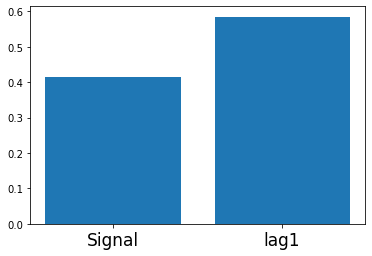

In [24]:
# get importance
rf_lr.fit(X_train, y_train)

importance = rf_lr['RandomForest'].feature_importances_

# get index of top N important values
n = 10
indexes = sorted(range(len(importance)), key=lambda i: importance[i])[-n:]
impt_features = []
impt_features_score = []
# summarize feature importance
for i in indexes:
 impt_features.append(features[i])
 impt_features_score.append(importance[i])
# plot feature importance
plt.xticks(fontsize=17)

plt.bar(impt_features, impt_features_score)
plt.show()

## ARIMA Model

Actual Adj Close Price vs Predicted Adj Close Price
Root Mean Squared Error: 1.49
Mean Absolute Error: 1.13
Std: 0.12


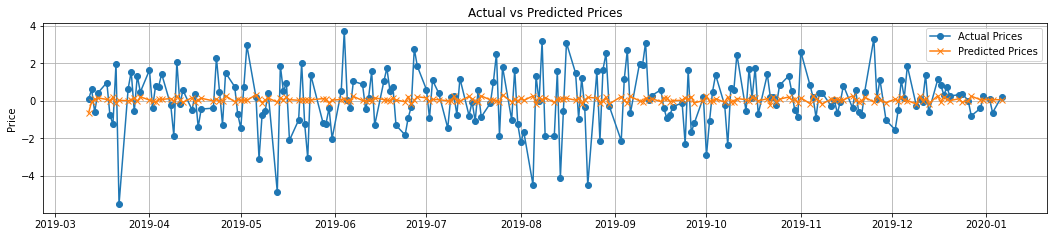

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  828
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1945.623
Date:                Mon, 10 Jun 2024   AIC                           3899.245
Time:                        18:58:31   BIC                           3918.121
Sample:                             0   HQIC                          3906.485
                                - 828                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0497      0.071      0.695      0.487      -0.090       0.190
Signal        -0.1399      0.144     -0.972      0.331      -0.422       0.142
ma.L1         -0.4559      0.009    -53.390      0.0

In [25]:
# For fair test, let's get the same test size as the regressors
test_size = len(y_test)

# Modify df for time-series model
df_arima = df_for_regression.copy()
df_arima = df_arima.set_index('Date').asfreq('D').dropna() 
features = ["Signal"]

X, y, X_train, X_test, y_train, y_test = get_standard_train_test_split(df_arima[["y"] + features], test_ratio=0.2, is_not_time_series = False)

model = ARIMA(y_train, X_train, order=(0,0,1))
arima_fit = model.fit()
# Predict future prices using the signal
pred = arima_fit.forecast(steps = len(X_test), exog = X_test).values

mae = mean_absolute_error(pred, y_test)
rmse = mean_squared_error(pred, y_test) ** 0.5

models_performance["Arima"] = [mae, rmse, np.std(pred)]

# models_performance["Lasso"] = [mae, r2, np.std(pred)]

print(f'\033[1mActual Adj Close Price vs Predicted Adj Close Price\033[0m')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Std: {np.std(pred):.2f}')

# To visualise the performance of the model
plt.figure(figsize = (18, 3.5))
plt.plot(y_test.index, y_test.values, label = 'Actual Prices', marker = 'o')
plt.plot(y_test.index, pred, label = 'Predicted Prices', marker = 'x')
plt.title('Actual vs Predicted Prices')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

print(arima_fit.summary())

In [26]:
pd.DataFrame.from_dict(models_performance, orient='index', columns=["MAE", "RMSE", "STD"])

,MAE,RMSE,STD
Naive,1.719139,2.203245,1.498380
Lasso,1.127874,1.505946,0.396246
RandomForest,1.274325,1.754915,1.008627
Arima,1.126627,1.493407,0.120163
